In [1]:
# Importing the libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import tensorflow as tf
from tensorflow.keras import layers, models,Sequential, callbacks # type: ignore
from tcn import TCN
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [2]:
# input_file = 'Cell_Phones.json'  
# output_file = 'Cell_Phones.csv'  

# Here,we are reading the JSON file and have to store each line as a JSON object in a list.
# data = []
# with open(input_file, 'r', encoding = 'utf-8') as f:
#     for line in f:
#         data.append(json.loads(line))

# df = pd.DataFrame(data)
# df.to_csv(output_file, index = False)

# print(f"Conversion is Successful!")

In [3]:
# Importing the data.

data = pd.read_csv("Cell_Phones.csv")

In [4]:
data.shape

(20812945, 10)

In [5]:
# Removing all those reviews that are not helpful and dropping images column.

data = data[data["helpful_vote"] > 0]
data.drop(columns = ["images","user_id","asin","parent_asin"],inplace = True)

data.shape

(3088218, 6)

In [6]:
data.head()

,rating,title,text,timestamp,helpful_vote,verified_purchase
1,5.0,Awesome! Great price! Works well!,Perfect. How pissed am I that I recently paid ...,1534443517349,2,True
2,5.0,Worked but took an hour to install,Overall very happy with the end result. If you...,1629235304798,3,True
10,5.0,These work!,These really work! I like having one in my bat...,1557757060457,1,True
20,5.0,Simple and works,Fits and stays in vent while holding a moto x ...,1427591745000,1,True
29,5.0,Five Stars,"Yep, this is what I expected",1495246335000,1,True


In [7]:
# Setting the date of every review by parsing the timestamp.

data["date"] = pd.to_datetime(data["timestamp"],unit = "ms")
data.drop(columns = ["timestamp"],inplace = True)
data.set_index("date",inplace = True)
data.sort_index(inplace = True)

data.head()

,rating,title,text,helpful_vote,verified_purchase
date,,,,,
1998-02-19 03:08:19,5.0,Ruth Moore is a genius in telling the story of...,Spoonhandle is a compelling story of an island...,21,False
1999-11-18 07:16:05,5.0,Inexpensive gem,"I bought mine a few months ago, and have had n...",13,False
1999-12-26 16:46:53,5.0,Magical.......,Very heartfelt and sentimental and a CLASSIC i...,4,False
2000-01-20 19:12:41,5.0,Wonderfully Creepy,One of the best of the 1940's era horror films...,7,False
2000-01-28 19:46:10,3.0,Interesting...........but not that interesting,I've seen the movie twice and I found it much ...,1,False


In [8]:
# Initialize the Sentiment Intensity Analyzer.

analyzer = SentimentIntensityAnalyzer()

In [9]:
# Running the Sentiment Intensity Analyzer on the review text.

reviews = data["text"].astype(str)

sentiments = reviews.apply(lambda x: analyzer.polarity_scores(x))

vader_scores = []

for sentiment in sentiments:
    compound = sentiment["compound"]
    vader_scores.append((compound + 1)/2)

In [10]:
# Fetching the rating scores of all the reviews.

rating_scores = []

ratings = data["rating"].astype(int)
for rating in ratings:
    rate = rating / 5
    rating_scores.append(rate)

In [11]:
# Combining the rating scores and the VADER scores to get a final score.

scores = []

for rating,vader in zip(rating_scores,vader_scores):
    score = (0.5 * rating) + (0.5 * vader)
    scores.append(round(score,3))    

In [14]:
# Fetching the count of positive and negative reviews.
# 0.5 is the threshold for positive and negative reviews.

p = n = 0

for score in scores:
    if score >= 0.5:
        p += 1
    elif score < 0.5:
        n += 1
print(f"Positive Reviews: {p},Negative Reviews: {n}")

Positive Reviews: 2341961,Negative Reviews: 746257


In [15]:
# Creating a new feature "sentiment" in the dataset.

data["sentiment"] = scores

In [14]:
# Checking for the null values in the sentiment score.

data["sentiment"].isna().sum()

np.int64(0)

In [19]:
# Resampling the data to obtain mean sentiment scores on a daily basis and interpolating the missing values.

daily_data = data["sentiment"].resample("D").mean()
daily_data = daily_data[daily_data.index.year < 2023]
daily_data.interpolate(method = "time",inplace = True)
daily_data = round(daily_data,3)

In [20]:
daily_data.shape

(9082,)

In [21]:
daily_data.tail()

date
2022-12-27    0.757
2022-12-28    0.756
2022-12-29    0.759
2022-12-30    0.746
2022-12-31    0.751
Freq: D, Name: sentiment, dtype: float64

In [22]:
# Function to create the sliding windows.
# The function takes a time series and creates overlapping windows of size L for the input and H for the output.

def create_sliding_windows(series, L, H):
    X, Y = [], []
    for i in range(len(series) - L - H + 1):
        X.append(series[i : i + L])
        Y.append(series[i + L: i + L + H])
    return np.array(X), np.array(Y)

In [ ]:
# Function to build Bidirectional LSTM model.

def build_model(L, H):
    model = models.Sequential([
        layers.Input(shape = (L, 1)),
        layers.LSTM(64),
        layers.Dense(H)
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss = 'mse'
    )
    return model

In [24]:
# Baseline 1: Moving Average Forecast.
def moving_average_forecast(X_test, L, H):
    return np.array([x[-L:].mean() for x in X_test]).repeat(H).reshape(-1, H)

In [25]:
# Model 1: TCN (Temporal Convolutional Network).
# The TCN model is a type of neural network architecture that is particularly well-suited for sequence modeling tasks.

def build_tcn_model(L, H):
    model = Sequential([
        layers.Input(shape=(L, 1)),
        TCN(
            nb_filters = 64,
            kernel_size = 3,
            dilations = [1, 2, 4, 8, 16],
            return_sequences = False,
            use_batch_norm = True,
            use_layer_norm = False,
            padding = 'causal'
        ),
        layers.Dense(128, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(H)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [26]:
# Model 2: Transformers.

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

    def call(self, x):
        seq_len = tf.shape(x)[1]
        i = tf.cast(tf.range(start = 0, limit = self.d_model, delta = 1), tf.float32)
        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)

        angle_rates = 1 / tf.pow(10000., (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        angle_rads = pos * angle_rates

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]  

        return x + pos_encoding
    
def transformer_ffn(x, d_model):
    return tf.keras.Sequential([
        layers.Dense(d_model * 4, activation='relu'),
        layers.Dense(d_model),
    ])(x)
    
def build_transformer_model(L, H, d_model = 64, num_heads = 2):
    inputs = tf.keras.Input(shape=(L, 1))

    # Project input to d_model and apply positional encoding
    x = layers.Dense(d_model)(inputs)
    x = PositionalEncoding(d_model)(x)

    # Multi-Head Attention + Residual + Normalization.
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = layers.Dropout(0.1)(attn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    # Feed-Forward Network + Residual + Normalization.
    ffn_output = transformer_ffn(x, d_model)
    ffn_output = layers.Dropout(0.1)(ffn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(H)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [27]:
# Function to calculate Symmetric Mean Absolute Percentage Error for the model.

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0 
    return np.mean(diff) * 100


In [ ]:
# Function to run forecasting on our data and plot the results for our model as well as State-of-the-art models.

def run_forecasting(data):
    results = {"Models":["BiDirectional LSTM","Temporal Convolutional Network","Transformer","Moving Average Forecast"],"MSE":[],"RMSE":[],"MAE":[]}
    L = 21 # Input window length (21 x 1D = 12 days)
    H = 3  # Forecast horizon (3 x 1D = 3 days)

    X, Y = create_sliding_windows(data, L, H)

    N = len(X)
    X_train, Y_train = X[ : int(0.8 * N)], Y[ : int(0.8 * N)]
    X_val, Y_val = X[int(0.8 * N):int(0.9 * N)], Y[int(0.8 * N):int(0.9 * N)]
    X_test, Y_test = X[int(0.9 * N):], Y[int(0.9 * N):]

    model = build_model(L, H)
    early_stop = callbacks.EarlyStopping(patience = 5, restore_best_weights = True)
    model.fit(
        X_train, Y_train,
        validation_data = (X_val, Y_val),
        epochs = 50,
        callbacks = [early_stop],
        batch_size = 64,
        verbose = 0
    )
    tcn_model = build_tcn_model(L, H)
    tcn_model.fit(
        X_train, Y_train,
        validation_data = (X_val, Y_val),
        epochs = 50,
        batch_size = 64,
        callbacks = [early_stop],
        verbose = 0
    )
    transformer_model = build_transformer_model(L, H)
    transformer_model.fit(
        X_train, Y_train,
        validation_data = (X_val, Y_val),
        epochs = 50,
        batch_size = 64,
        callbacks = [early_stop],
        verbose = 0
    )   
    
    test_loss = model.evaluate(X_test, Y_test, verbose = 0)
    results["MSE"].append(test_loss)
    results["RMSE"].append(np.sqrt(test_loss))
    results["MAE"].append(mean_absolute_error(Y_test, model.predict(X_test)))
    
    tcn_test_loss = tcn_model.evaluate(X_test, Y_test, verbose = 0)
    results["MSE"].append(tcn_test_loss)
    results["RMSE"].append(np.sqrt(tcn_test_loss))
    results["MAE"].append(mean_absolute_error(Y_test, tcn_model.predict(X_test)))
    
    trans_test_loss = transformer_model.evaluate(X_test, Y_test, verbose = 0)
    results["MSE"].append(trans_test_loss)
    results["RMSE"].append(np.sqrt(trans_test_loss))
    results["MAE"].append(mean_absolute_error(Y_test, transformer_model.predict(X_test)))
  
    Y_pred = model.predict(X_test)
    moving_preds = moving_average_forecast(X_test, L, H)
    tcn_preds = tcn_model.predict(X_test)
    transformer_preds = transformer_model.predict(X_test)
    ma_loss = mean_squared_error(Y_test,moving_preds)
    results["MSE"].append(ma_loss)
    results["RMSE"].append(np.sqrt(ma_loss))
    results["MAE"].append(mean_absolute_error(Y_test, moving_preds))
  
    
    print(f"Mean Squared Error on Test (BiDirectional LSTM): {test_loss:.4f}")
    print(f"Mean Squared Error on Test (TCN Forecast): {tcn_test_loss:.4f}")
    print(f"Mean Squared Error on Test (Transformer Forecast): {trans_test_loss:.4f}")
    print(f"Mean Squared Error on Test (Moving Average Forecast): {ma_loss:.4f}")    
     
    transformer_pred = transformer_preds[:, 0]
    Y_pred_first = Y_pred[:, 0]
    Y_test_first = Y_test[:, 0]
    tcn_pred = tcn_preds[:, 0]
    moving_pred = moving_preds[:, 0]
        
    forecast_start_idx = L + int(0.9 * N)
    flat_time = data.index[forecast_start_idx : forecast_start_idx + len(Y_test_first)]
    
    fig, axs = plt.subplots(4, 1, figsize=(10, 15))  

    # Plot data in the first subplot.
    axs[0].plot(flat_time, Y_test_first, label = "True")
    axs[0].plot(flat_time, Y_pred_first, label = "BiDirectional LSTM Forecast")
    axs[0].set_title(f'Actual vs BiDirectional LSTM Forecast(MSE: {test_loss:.4f})')
    axs[0].legend()
        
    # Plot data in the second subplot.
    axs[1].plot(flat_time, Y_test_first, label = "True")
    axs[1].plot(flat_time, moving_pred,label = "Moving Average Forecast")
    axs[1].set_title(f'Actual vs Moving Average Forecast (MSE: {ma_loss:.4f})')
    axs[1].legend()
        
    # Plot data in the third subplot.
    axs[2].plot(flat_time, Y_test_first, label = "True")
    axs[2].plot(flat_time, tcn_pred,label = "TCN Forecast")
    axs[2].set_title(f'Actual vs TCN Forecast (MSE: {tcn_test_loss:.4f})')
    axs[2].legend()
        
    # Plot data in the fourth subplot.    
    axs[3].plot(flat_time, Y_test_first, label = "True")
    axs[3].plot(flat_time, transformer_pred,label = "Transformer Forecast")
    axs[3].set_title(f'Actual vs Transformer Forecast (MSE: {trans_test_loss:.4f})')
    axs[3].legend()
    
    plt.show()
    return results

[[0.938 0.938 0.938 ... 0.939 0.939 0.939]
 [0.938 0.938 0.938 ... 0.939 0.939 0.939]
 [0.938 0.938 0.938 ... 0.939 0.939 0.939]
 ...
 [0.701 0.687 0.67  ... 0.7   0.73  0.713]
 [0.687 0.67  0.688 ... 0.73  0.713 0.72 ]
 [0.67  0.688 0.685 ... 0.713 0.72  0.718]] [[0.939 0.939 0.939]
 [0.939 0.939 0.939]
 [0.939 0.939 0.939]
 ...
 [0.72  0.718 0.723]
 [0.718 0.723 0.718]
 [0.723 0.718 0.723]]
[[0.695 0.708 0.688 ... 0.736 0.715 0.704]
 [0.708 0.688 0.692 ... 0.715 0.704 0.719]
 [0.688 0.692 0.711 ... 0.704 0.719 0.73 ]
 ...
 [0.747 0.749 0.747 ... 0.752 0.734 0.745]
 [0.749 0.747 0.748 ... 0.734 0.745 0.757]
 [0.747 0.748 0.755 ... 0.745 0.757 0.756]] [[0.719 0.73  0.708]
 [0.73  0.708 0.717]
 [0.708 0.717 0.712]
 ...
 [0.757 0.756 0.759]
 [0.756 0.759 0.746]
 [0.759 0.746 0.751]]
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
29/29 ━━━━━━━

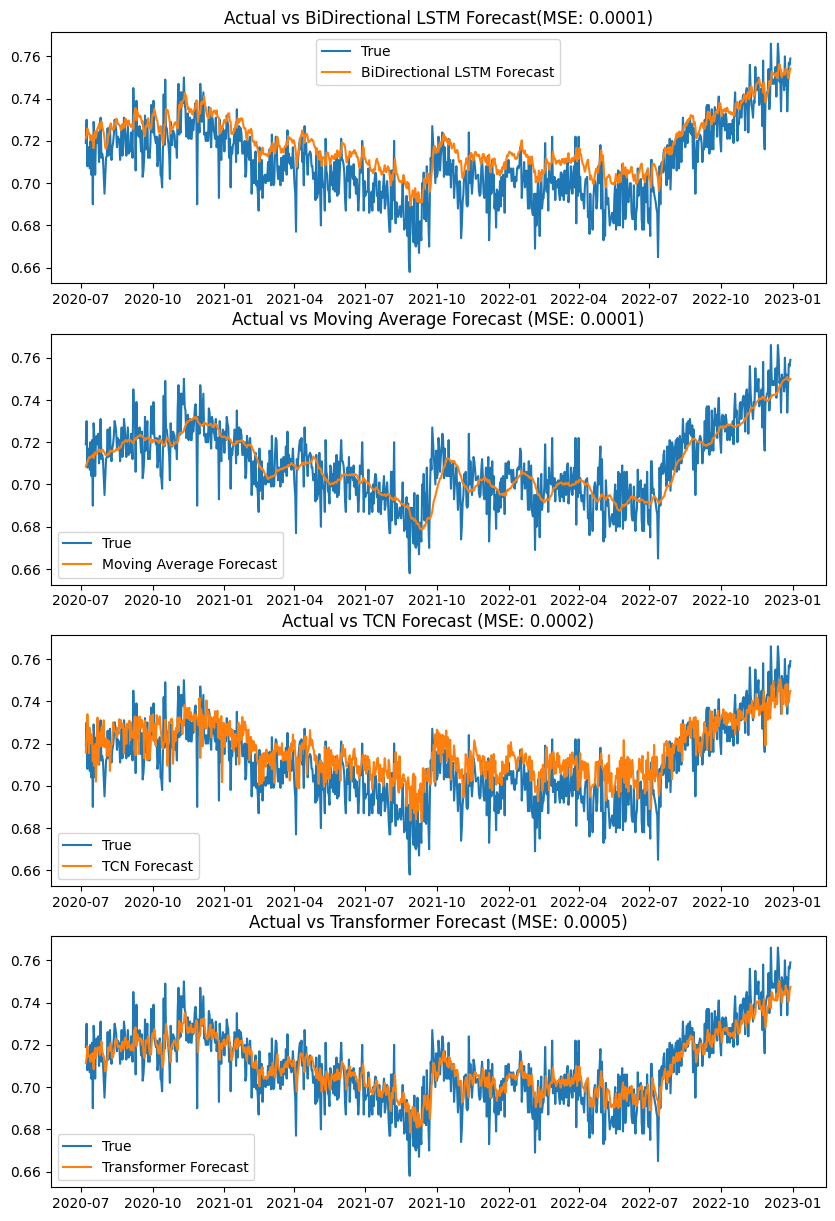

In [30]:
# Running the forecasting function on our data.

result = run_forecasting(daily_data)

In [31]:
# Creating a DataFrame to store the results.

results_df = pd.DataFrame(result)
results_df.set_index("Models", inplace = True)

In [32]:
results_df.sort_values("MSE", ascending = True, inplace = True)

In [33]:
results_df

,MSE,RMSE,MAE
Models,,,
Moving Average Forecast,0.000112,0.010568,0.008267
BiDirectional LSTM,0.000148,0.012182,0.009709
Temporal Convolutional Network,0.000246,0.015670,0.012441
Transformer,0.000543,0.023302,0.018950
